
# 🧪 Network-Based Disease Analysis — Student Exercise

This practical guides you through:
- **Reading** three input files and converting them to useful Python structures.
- **Building** a PPI network with NetworkX.
- **Measuring connectivity** of disease gene sets (Largest Connected Component, **LCC**).
- **Assessing significance** with a **Z-score** (vs. random expectation) and **two-tailed p-value**.
- **Characterizing disease genes** via **centrality** metrics and finding the most central genes/diseases.

> **Files**
> - `rare_disease_genes.tsv` — columns: `disease`, `gene` (semicolon-`;` separated gene symbols per row)  
> - `ppi.tsv` — columns: `Gene Name Interactor A`, `Gene Name Interactor B` (edge list)  
> - `drugs_drugbank_symbol.tsv` — first col = drug name; remaining cols = targets


In [1]:

import pandas as pd
import networkx as nx
import numpy as np
import random
import statistics as stat
from math import erf, sqrt

random.seed(42)
np.random.seed(42)


/var/folders/4v/d4kckh657r79_ny0v3wxl8xh0000gp/T/ipykernel_30996/2929879363.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1) Read input files and build dictionaries

In [2]:

# === 1A) rare_disease_genes.tsv → dict[disease] = list of genes ===
rdg_df = pd.read_csv('data/rare_disease_genes.tsv', sep='\t')

expected_cols = {'disease','gene'}
if not expected_cols.issubset(set(rdg_df.columns)):
    raise ValueError(f"rare_disease_genes.tsv must have columns {expected_cols}, found {set(rdg_df.columns)}")

def split_genes(cell):
    if pd.isna(cell):
        return []
    parts = [g.strip() for g in str(cell).split(';')]
    return [g for g in parts if g]

rdg_df['gene_list'] = rdg_df['gene'].apply(split_genes)

disease_to_genes = (
    rdg_df.groupby('disease')['gene_list']
    .apply(lambda lists: sorted(set(g for lst in lists for g in lst)))
    .to_dict()
)

print(f"Loaded {len(disease_to_genes)} disease groups from rare_disease_genes.tsv")
for i, (k,v) in enumerate(disease_to_genes.items()):
    print(f"  • {k}: {len(v)} genes (example: {v[:5]})")
    if i>=2: break


Loaded 28 disease groups from rare_disease_genes.tsv
  • Ciliopathy: 225 genes (example: ['ABCA4', 'ADAM9', 'ADGRV1', 'AGBL5', 'AHI1'])
  • Genetic infertility: 237 genes (example: ['A2ML1', 'ABCD1', 'ADGRG2', 'AK7', 'AMH'])
  • Genetic otorhinolaryngologic disease: 198 genes (example: ['ABHD12', 'ACTB', 'ADAMTSL1', 'ADGRV1', 'AIFM1'])


## 2) Read PPI edge list and build the NetworkX graph

In [4]:

ppi_df = pd.read_csv('data/ppi.tsv', sep='\t')

req_cols_ppi = {'Gene Name Interactor A', 'Gene Name Interactor B'}
if not req_cols_ppi.issubset(set(ppi_df.columns)):
    raise ValueError(f"ppi.tsv must have columns {req_cols_ppi}, found {set(ppi_df.columns)}")

ppi_df = ppi_df.rename(columns={'Gene Name Interactor A':'A','Gene Name Interactor B':'B'})

G = nx.from_pandas_edgelist(ppi_df, 'A', 'B')
print(f"PPI network: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")


PPI network: 17,945 nodes, 384,666 edges


## 3) Read DrugBank drug–target table and build dictionary

In [5]:

drug_to_targets = {}
with open('data/drugs_drugbank_symbol.tsv', 'r') as f:
    for line in f:
        parts = line.rstrip('\n').split('\t')
        if not parts:
            continue
        drug = parts[0].strip()
        targets = [t.strip() for t in parts[1:] if t.strip()]
        if drug:
            drug_to_targets[drug] = targets

print(f"Loaded {len(drug_to_targets)} drugs from drugs_drugbank_symbol.tsv")
example = next(iter(drug_to_targets.items()))
print(f"Example: {example[0]} → {example[1][:5]}")


Loaded 6213 drugs from drugs_drugbank_symbol.tsv
Example: Asparaginase Escherichia coli → ['TBG']


## 4) LCC utilities

In [6]:

def lcc_size_for_genes(G, genes):
    genes_in_net = set(G.nodes()).intersection(genes)
    if not genes_in_net:
        return 0, 0  # (lcc_size, genes_in_net_count)
    sub = G.subgraph(genes_in_net)
    comps = nx.connected_components(sub)
    lcc = max(comps, key=len) if sub.number_of_nodes() > 0 else set()
    return len(lcc), len(genes_in_net)

def phi(x):
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def z_and_p(observed, samples):
    mu = stat.mean(samples) if samples else 0.0
    sd = stat.stdev(samples) if len(samples) > 1 else 0.0
    if sd == 0:
        sd = 1e-12
    z = (observed - mu) / sd
    p = 2.0 * (1.0 - phi(abs(z)))
    return z, p, mu, sd


## 5) LCC per disease + significance (Z, p-value)

In [9]:

N_TRIALS = 1000
all_nodes = list(G.nodes())

lcc_rows = []
for group, genes in disease_to_genes.items():
    genes = set(genes)
    obs_lcc, n_in_net = lcc_size_for_genes(G, genes)
    rand_sizes = []
    for _ in range(N_TRIALS):
        if n_in_net > 0:
            rnd = random.sample(all_nodes, n_in_net)
            rnd_lcc, _ = lcc_size_for_genes(G, rnd)
        else:
            rnd_lcc = 0
        rand_sizes.append(rnd_lcc)
    z, p, mu, sd = z_and_p(obs_lcc, rand_sizes)
    lcc_rows.append({
        'group': group,
        'no_genes': len(genes),
        'genes_in_net': n_in_net,
        'lcc_size': obs_lcc,
        'lcc_rel': (obs_lcc / n_in_net) if n_in_net else 0.0,
        'rand_mean': mu,
        'rand_sd': sd,
        'zscore': z,
        'pval_two_tailed': p
    })

lcc_df = pd.DataFrame(lcc_rows).sort_values('zscore', ascending=False).reset_index(drop=True)
lcc_df.head(10)


,group,no_genes,genes_in_net,lcc_size,lcc_rel,rand_mean,rand_sd,zscore,pval_two_tailed
0,RASopathy,20,20,15,0.750000,1.401,0.669812,20.302722,0.000000e+00
1,Rare genetic systemic or rheumatologic disease,79,78,47,0.602564,4.790,3.171428,13.309460,0.000000e+00
2,Laminopathy,26,26,13,0.500000,1.617,0.916051,12.426159,0.000000e+00
3,Rare genetic tumor,142,138,107,0.775362,13.149,8.753366,10.721704,0.000000e+00
4,Inherited cancer-predisposing syndrome,180,176,155,0.880682,21.278,12.548792,10.656165,0.000000e+00
5,Rare genetic neurological disorder,1649,1569,1425,0.908222,1026.244,38.341342,10.400158,0.000000e+00
6,Rare genetic developmental defect during embry...,1598,1534,1355,0.883312,996.458,38.505154,9.311533,0.000000e+00
7,Rare genetic vascular disease,22,21,7,0.333333,1.399,0.618208,9.060057,0.000000e+00
8,Rare genetic eye disease,967,907,735,0.810364,478.983,32.348805,7.914265,2.442491e-15
9,Rare genetic bone disease,508,498,384,0.771084,184.450,26.092611,7.647759,2.042810e-14


## 6) Centrality analysis — per gene, per disease

In [10]:

degree_c = nx.degree_centrality(G)
try:
    eigen_c = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    eigen_c = {n: np.nan for n in G.nodes()}
betw_c = nx.betweenness_centrality(G, k=min(500, G.number_of_nodes()))

centrality_df = pd.DataFrame({'gene': list(G.nodes())}).assign(
    degree=lambda df: df['gene'].map(degree_c),
    betweenness=lambda df: df['gene'].map(betw_c),
    eigenvector=lambda df: df['gene'].map(eigen_c)
)

centrality_df.head()


,gene,degree,betweenness,eigenvector
0,ALDH1A1,0.000502,0.000002,0.000762
1,ITGA7,0.001672,0.000052,0.000312
2,CHRNA1,0.000223,0.000001,0.000005
3,PPP1R9A,0.002285,0.000009,0.002564
4,ACTG1,0.012428,0.000351,0.021791


## 7) Aggregate centrality per disease & find most central genes/diseases

In [11]:

disease_summary = []
top_genes_per_disease = []

for group, genes in disease_to_genes.items():
    genes_in_net = set(genes).intersection(centrality_df['gene'])
    sub = centrality_df[centrality_df['gene'].isin(genes_in_net)]
    if sub.empty:
        disease_summary.append({
            'group': group, 'n_genes': len(genes), 'n_in_net': 0,
            'mean_degree': 0.0, 'mean_betweenness': 0.0, 'mean_eigenvector': 0.0
        })
        continue
    disease_summary.append({
        'group': group,
        'n_genes': len(genes),
        'n_in_net': len(genes_in_net),
        'mean_degree': sub['degree'].mean(),
        'mean_betweenness': sub['betweenness'].mean(),
        'mean_eigenvector': sub['eigenvector'].mean()
    })
    for m in ['degree','betweenness','eigenvector']:
        top_row = sub.sort_values(m, ascending=False).head(1)
        if not top_row.empty:
            top_genes_per_disease.append({
                'group': group,
                'metric': m,
                'gene': top_row['gene'].values[0],
                'value': top_row[m].values[0]
            })

disease_centrality_df = pd.DataFrame(disease_summary).sort_values('mean_degree', ascending=False).reset_index(drop=True)
top_genes_df = pd.DataFrame(top_genes_per_disease)

print("Per-disease centrality averages (top 10 by mean degree):")
display(disease_centrality_df.head(10))

print("\nMost central gene per disease and metric (first 15 rows):")
display(top_genes_df.head(15))


Per-disease centrality averages (top 10 by mean degree):


,group,n_genes,n_in_net,mean_degree,mean_betweenness,mean_eigenvector
0,Rare genetic tumor,142,138,0.008682,0.000920,0.010347
1,Inherited cancer-predisposing syndrome,180,176,0.007518,0.000667,0.010494
2,RASopathy,20,20,0.006370,0.000220,0.007653
3,Rare genetic systemic or rheumatologic disease,79,78,0.005239,0.001054,0.005265
4,Laminopathy,26,26,0.005176,0.000580,0.007064
5,Rare genetic gastroenterological disease,140,139,0.004962,0.000444,0.005555
6,Rare genetic vascular disease,22,21,0.004275,0.000250,0.004704
7,Rare genetic bone disease,508,498,0.004221,0.000227,0.005257
8,Rare chromosomal anomaly,151,145,0.004173,0.000173,0.005853
9,Rare genetic neurological disorder,1649,1569,0.003878,0.000220,0.005028



Most central gene per disease and metric (first 15 rows):


,group,metric,gene,value
0,Ciliopathy,degree,PRPF8,0.032434
1,Ciliopathy,betweenness,PRPF8,0.003030
2,Ciliopathy,eigenvector,PRPF8,0.064751
3,Genetic infertility,degree,ESR1,0.060856
4,Genetic infertility,betweenness,LMNA,0.010082
5,Genetic infertility,eigenvector,ESR1,0.082225
6,Genetic otorhinolaryngologic disease,degree,ACTB,0.028868
7,Genetic otorhinolaryngologic disease,betweenness,ACTB,0.004955
8,Genetic otorhinolaryngologic disease,eigenvector,ACTB,0.046694
9,Inherited cancer-predisposing syndrome,degree,ESR2,0.141607


## 8) Identify the most central diseases (by average metrics)

In [13]:

most_central_by_degree = disease_centrality_df.sort_values('mean_degree', ascending=False).head(5)[['group','mean_degree']]
most_central_by_betw   = disease_centrality_df.sort_values('mean_betweenness', ascending=False).head(5)[['group','mean_betweenness']]
most_central_by_eigen  = disease_centrality_df.sort_values('mean_eigenvector', ascending=False).head(5)[['group','mean_eigenvector']]

print("Top diseases by mean degree centrality:")
display(most_central_by_degree)
print("\nTop diseases by mean betweenness centrality:")
display(most_central_by_betw)
print("\nTop diseases by mean eigenvector centrality:")
display(most_central_by_eigen)


Top diseases by mean degree centrality:


,group,mean_degree
0,Rare genetic tumor,0.008682
1,Inherited cancer-predisposing syndrome,0.007518
2,RASopathy,0.006370
3,Rare genetic systemic or rheumatologic disease,0.005239
4,Laminopathy,0.005176



Top diseases by mean betweenness centrality:


,group,mean_betweenness
3,Rare genetic systemic or rheumatologic disease,0.001054
0,Rare genetic tumor,0.000920
1,Inherited cancer-predisposing syndrome,0.000667
4,Laminopathy,0.000580
5,Rare genetic gastroenterological disease,0.000444



Top diseases by mean eigenvector centrality:


,group,mean_eigenvector
1,Inherited cancer-predisposing syndrome,0.010494
0,Rare genetic tumor,0.010347
2,RASopathy,0.007653
4,Laminopathy,0.007064
11,Rare genetic hematologic disease,0.006181


## 9) Create network visualisation of a specific disease

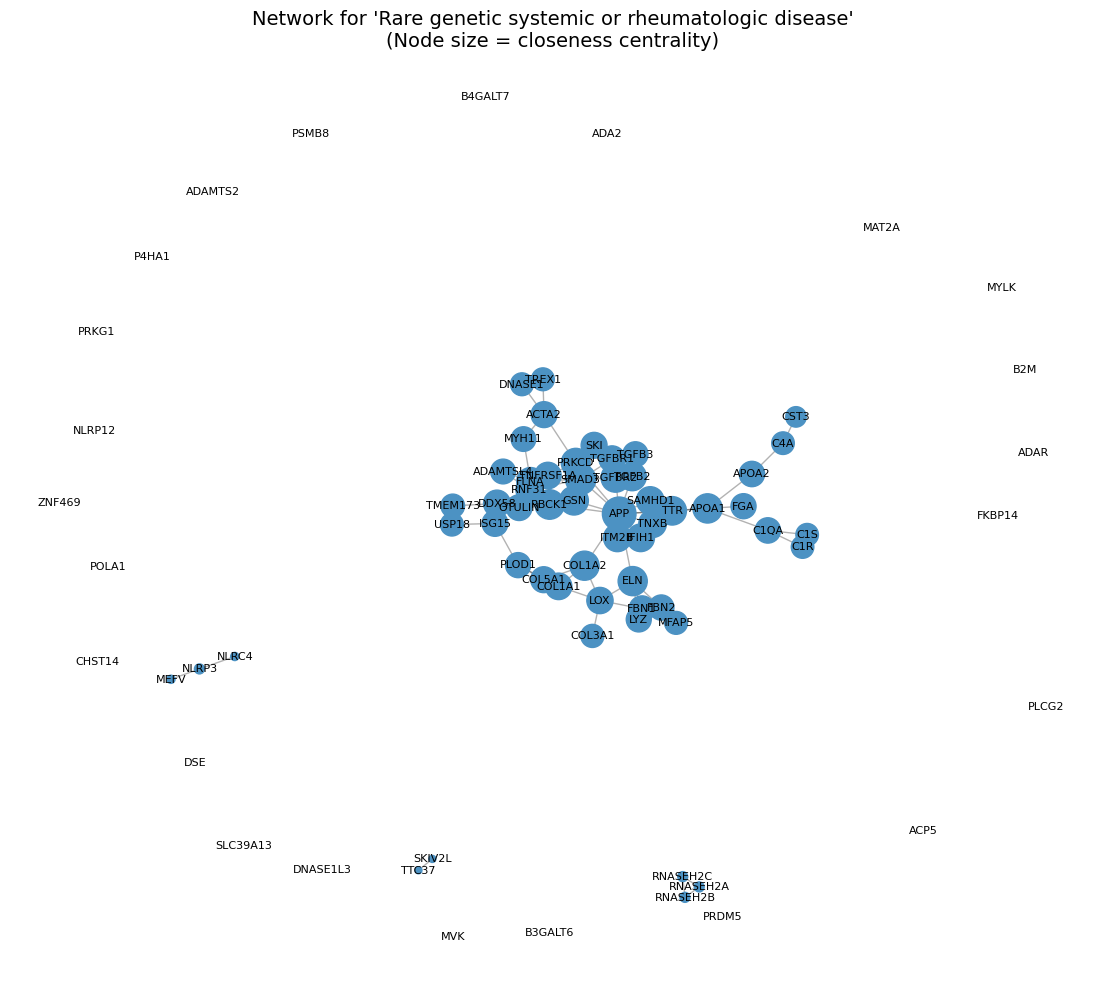

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

# --- Select disease to visualize ---
disease_name = "Rare genetic systemic or rheumatologic disease"

# Get list of genes for this disease
rows = rdg_df.loc[rdg_df['disease'] == disease_name, 'gene_list']
if len(rows) == 0:
    raise ValueError(f"Disease name '{disease_name}' not found.")
genes = set(rows.sum())

# Keep only genes that are present in the PPI network
genes_in_net = genes.intersection(G.nodes())

# Extract subgraph
subG = G.subgraph(genes_in_net).copy()

# Remove self-loops if any exist
subG.remove_edges_from(nx.selfloop_edges(subG))

if len(subG) == 0:
    print("⚠️ None of the genes for this disease are present in the network.")
else:
    # Compute closeness centrality
    closeness = nx.closeness_centrality(subG)

    # Scale node sizes based on closeness values
    node_sizes = [closeness[g] * 2000 for g in subG.nodes()]

    # Layout for visualization
    pos = nx.spring_layout(subG, seed=42)  # deterministic layout

    # Plot
    plt.figure(figsize=(14, 12))
    nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color="#4C92C3")
    nx.draw_networkx_edges(subG, pos, alpha=0.3)
    nx.draw_networkx_labels(subG, pos, font_size=8)

    plt.title(f"Network for '{disease_name}'\n(Node size = closeness centrality)", fontsize=14)
    plt.axis("off")
    plt.show()


---

## 🔧 Extension Tasks
1. **Increase** `N_TRIALS` to 10_000 to get more stable Z-scores (expect longer runtime).
2. **Plot** LCC z-scores per disease (bar plot) and highlight significant ones (e.g., p < 0.05).
3. **Drug–disease proximity**: for each disease, compute average shortest-path distance to each drug's targets; then compute a z-score vs random target sets of the same size.
4. **Pathway enrichment**: explore enrichment among top-central genes for a disease of your choice.
